# ECE 143 Individual Project

Name: Yumeng Ruan  
PID: A53250267

# Problem

You have been asked to help with planning an ad-hoc communications network over a large rectangular region. Each individual tower can monitor a rectangular subsection of a specific width and height. The main problem is that none of the individual towers can provide coverage for the entire region of interest. Communications towers are unreliable and are put up independently and at random. You have no control over where or how big a tower’s footprint is placed. Importantly, due to technical issues such as cross-talk, no individual rectangular subsection can have multiple towers providing coverage for it. That is, there can be no overlap between any pair of rectangular subsections provided by the two respective towers. In any case, the desire is to maximize the coverage area of any available communications tower.

# Requirements

The order of when the towers come online is important. Once a tower has acquired its rectangular section, no subsequent tower can overlap that section. You may assume the following for this problem:

● All rectangular sections have integer-based corners.  
● All rectangular sections must be contained in the overall rectangular footprint.  
● The height and width of each rectangular section is sampled from a uniform distribution.  
● Positions of the windows are also determined by uniform random distribution.  
● All footprints must be rectangles (not general polygons).  
● When a new tower comes online, if its coverage rectangle intersects the pre-existing
composite footprint, then that new tower’s coverage is trimmed such that its maximum remaining coverage area is retained (see sequential diagram below).  

Write a detailed Jupyter notebook that implements a solution to this problem such that the user can supply the following overall size of desired coverage footprint and then determine the following:  

● Given an overall desired coverage footprint and a sequence of n communications towers, what   is the resulting resolved coverage?  
● What is the total area of coverage relative to the desired total coverage area of the         original footprint? That is, are there any gaps in coverage?  
● On average, how many communications towers are required before full coverage is obtained?  

# Discussion

Let's simplify this problem into 4 steps:  
1. At first, we can view a tower as a rectangle, we need a method to generate rectangles;  
2. Then input integer-based rectangles with random length and width sequently into a square region;    
3. Since we are required to check the overlapping section and then trim the wanting maximum non-overlapping rectangle, we need find the way;  
4. Repeat step3 until the whole square region is covered.

Follow these 4 steps we may find the result of the problem.

# Rectangle

In [2]:
class Rect(object):
    """The rectangle class
       A rectangle has four corners: x1,x2,x3,x4, where x1 represents bottom left,
       x2 represent bottom right, x3 represent top left and x4 represents top right."""
    
    def __init__(self, start, l, w):
        """Initialize function
           A legal rectangle can be determined by one start position plus length and width.
           We define the bottom left of a rectangle as the start position of it
           and length in x-axis and width in y-axis"""
        
        assert isinstance(start,tuple)
        assert isinstance(l,int)
        assert isinstance(w,int)
        
        self.x1 = start
        self.length = l
        self.width = w
        
    
    @property
    def x2(self):
        """Bottom right point"""
        return (self.x1[0] + self.length, self.x1[1])
    
    @property
    def x3(self):
        """Top left point"""
        return (self.x1[0], self.x1[1] + self.width)
    
    @property
    def x4(self):
        """Top right point"""
        return (self.x1[0] + self.length, self.x1[1] +self.width)
    
    def __repr__(self):
        return "Rectangle(%s,%s,%s,%s)" % (self.x1,self.x2,self.x3,self.x4)

    def __eq__(self,other):
        """We define equality of two rectangles if they are all the same"""
        return self.x1 == other.x1 and self.x2 == other.x2 and self.x3 == other.x3 and self.x4 == self.x4
    
    def __ge__(self,other):
        """We say one rectangle is greater or equal to another when it entirely contains another"""
        return self.x1[0]<=other.x1[0] and self.x1[1]<=other.x1[1] and self.x4[0]>=other.x4[0] and self.x4[1]>=other.x4[1]
    
    def __ne__(self,other):
        """We say two rectangles are inequal when they are not overlapped"""
        return self.x2[0] <= other.x1[0] or self.x1[0] >= other.x2[0] or self.x3[1] <= other.x1[1] or self.x1[1] >= other.x3[1]
    
    @property
    def area(self):
        """Calculate the area"""
        return self.length*self.width
        

# Generation

In [3]:
import random

def region(length,width,num):
    """
        Create a square region with where we input our rectangles.
        We want to input rectangles one by one, if a new input is overlapped with old ones,
        we will do the trim and retain a new trimmed rectangle.
        Our goal is to clarify if we can fully cover the whole region, 
        with a maximum number of rectangles.
        Also, for the conveniece to monitor the trimming processes, we will remain the non-trimmed
        rectangle into another list
        
        :Param: length: length of the region
                width: width of the region
                num: maximum number of rectangles we plan to input
        
        :Return: A list of rectangles which are all trimmed.
                 A list of rectangles where the new one has not been trimmed.
        
        """
    
    assert isinstance(num,int)
    assert isinstance(length,int)
    assert isinstance(width,int)
    assert length > 0
    assert width > 0
    assert num > 0
    
    rectlist = []
    oldlist = []
    area = length*width
    
    while len(rectlist) <= num:
        if total_area(rectlist) == area:
            break
        else:
            new_rect = create_new(length,width)
            
            if len(rectlist) == 0:
                rectlist.append(new_rect)
                oldlist.append(new_rect)
            else:
                oldlist.append(new_rect)
                for rect in rectlist:
                    new_rect = trim(rect,new_rect)
                rectlist.append(new_rect)
    
    return rectlist,oldlist

def create_new(length,width):
    """
        We need to generate rectangles and input them into the region one by one.
        This function can create rectangles randomly whose size should be less than the region.
        Also its start position must be valid to make the rectangle inside.
        
        :Param: length: length of the region
                width: width of the region
        
        :Return: A rectangle
        
        """
    
    assert isinstance(length,int)
    assert isinstance(width,int)
    assert length > 0
    assert width > 0

    l = random.randint(1,length)
    w = random.randint(1,width)
    x = random.randint(0,length-l)
    y = random.randint(0,width-w)
    
    return Rect((x,y),l,w)

def total_area(rectlist):
    """
        To calculate the total area of a list of rectangles,
        in order to check if they fully cover the region
        
        """
    
    assert isinstance(rectlist,list)
    
    total = 0
    for rect in rectlist:
        total += rect.area
    
    return total

# Trim
This might be the most important and hardest part in the project.  
Enumeration is the easiest way to think about, although there are a bunch of probable situations to discuss. 
So we will talk about two rectangles: an old one which has already existed and the new one which we want to trim.
As we all know a rectangle consists of four boundaries: left, right, bottom and top.  
Assume the four boundaries of two rectangles are l1,r1,b1,t1 and l2,r2,b2,t2, there are 4 situations when we compare their lefts and rights:
1. l2 >= l1 and r2 > r1;  
2. l2 < l1 and r2 <= r1;  
3. l2 < l1 and r2 > r1;  
4. l2 >= l1 and r2 <= r1.  
Each of them includes another 4 situations where their bottoms and tops are compared in the same sequence.  

In [4]:
def trim(R1,R2):
    """
       Trim two rectangles, return the new trimmed rectangle.
       if they are not overlapped, do nothing;
       if the new one are contained entirely, set the new to 0;
       if they intersect, then that new rectangle’s coverage is trimmed 
       such that its maximum remaining coverage area is retained 
       
       :Param: R1: Old rectangle which already exists.
               R2: A new input rectangle
       """
    
    if R1 != R2 or R2 == Rect((0,0),0,0):
        pass
    elif R1 >= R2:
        R2 = Rect((0,0),0,0)
    else:
        l1,r1,b1,t1 = R1.x1[0],R1.x2[0],R1.x1[1],R1.x3[1]
        l2,r2,b2,t2 = R2.x1[0],R2.x2[0],R2.x1[1],R2.x3[1]
        if not R1 != R2:
            if l2 >= l1 and r2 > r1:
                if b2 < b1 and t2 > t1:
                    A,B,C = Rect((l2,t1),r2-l2,t2-t1),Rect((l2,b2),r2-l2,b1-b2),Rect((r1,b2),r2-r1,t2-b2)
                    max_area = max(A.area,B.area,C.area)
                    if A.area == max_area:
                        R2 = A
                    elif B.area == max_area:
                        R2 = B
                    else:
                        R2 = C
                elif b2 < b1 and t2 <= t1:
                    A,B = Rect((l2,b2),r2-l2,b1-b2),Rect((r1,b2),r2-r1,t2-b2)
                    if A.area > B.area:
                        R2 = A
                    else:
                        R2 = B
                elif b2 >=b1 and t2 > t1:
                    A,B= Rect((l2,t1),r2-l2,t2-t1),Rect((r1,b2),r2-r1,t2-b2)
                    if A.area > B.area:
                        R2 = A
                    else:
                        R2 = B
                else:
                    R2 = Rect((r1,b2),r2-r1,t2-b2)
            
            elif l2 < l1 and r2 <= r1:
                if b2 < b1 and t2 > t1:
                    A,B,C = Rect((l2,t1),r2-l2,t2-t1),Rect((l2,b2),r2-l2,b1-b2),Rect((l2,b2),l1-l2,t2-b2)
                    max_area = max(A.area,B.area,C.area)
                    if A.area == max_area:
                        R2 = A
                    elif B.area == max_area:
                        R2 = B
                    else:
                        R2 = C
                elif b2 < b1 and t2 <= t1:
                    A,B = Rect((l2,b2),r2-l2,b1-b2),Rect((l2,b2),l1-l2,t2-b2)
                    if A.area > B.area:
                        R2 = A
                    else:
                        R2 = B
                elif b2 >=b1 and t2 > t1:
                    A,B= Rect((l2,t1),r2-l2,t2-t1),Rect((l2,b2),l1-l2,t2-b2)
                    if A.area > B.area:
                        R2 = A
                    else:
                        R2 = B
                else:
                    R2 = Rect((l2,b2),l1-l2,t2-b2)
            
            elif l2 < l1 and r2 > r1:
                if b2 < b1 and t2 > t1:
                    A,B,C,D = Rect((l2,t1),r2-l2,t2-t1),Rect((l2,b2),r2-l2,b1-b2),Rect((l2,b2),l1-l2,t2-b2),Rect((r1,b2),r2-r1,t2-b2)
                    max_area = max(A.area,B.area,C.area,D.area)
                    if A.area == max_area:
                        R2 = A
                    elif B.area == max_area:
                        R2 = B
                    elif C.area == max_area:
                        R2 = C
                    else:
                        R2 = D
                elif b2 < b1 and t2 <= t1:
                    A,B,C = Rect((l2,b2),r2-l2,b1-b2),Rect((l2,b2),l1-l2,t2-b2),Rect((r1,b2),r2-r1,t2-b2)
                    max_area = max(A.area,B.area,C.area)
                    if A.area == max_area:
                        R2 = A
                    elif B.area == max_area:
                        R2 = B
                    else:
                        R2 = C
                elif b2 >=b1 and t2 > t1:
                    A,B,C = Rect((l2,t1),r2-l2,t2-t1),Rect((l2,b2),l1-l2,t2-b2),Rect((r1,b2),r2-r1,t2-b2)
                    max_area = max(A.area,B.area,C.area)
                    if A.area == max_area:
                        R2 = A
                    elif B.area == max_area:
                        R2 = B
                    else:
                        R2 = C
                else:
                    A,B = Rect((l2,b2),l1-l2,t2-b2),Rect((r1,b2),r2-r1,t2-b2)
                    if A.area > B.area:
                        R2 = A
                    else:
                        R2 = B
            else:
                if b2 < b1 and t2 > t1:
                    A,B = Rect((l2,t1),r2-l2,t2-t1),Rect((l2,b2),r2-l2,b1-b2)
                    if A.area > B.area:
                        R2 = A
                    else:
                        R2 = B
                elif b2 < b1 and t2 <= t1:
                    R2 = Rect((l2,b2),r2-l2,b1-b2)
                else:
                    R2 = Rect((l2,t1),r2-l2,t2-t1)
    
    return R2        

# Visualize

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [10]:
length = 10
width = 10
num = 10

newlist,oldlist = region(length,width,num)

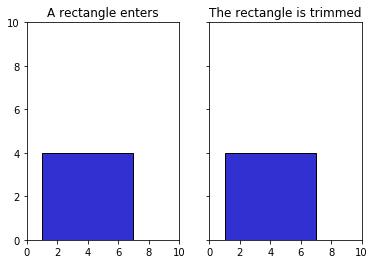

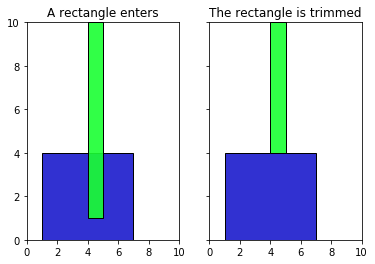

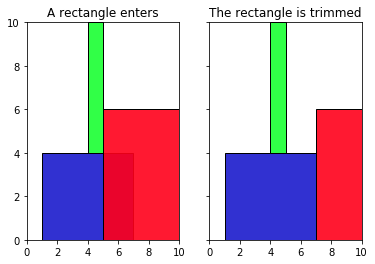

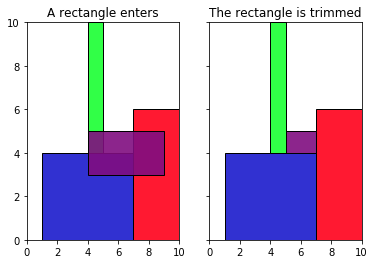

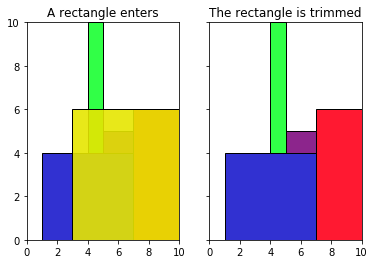

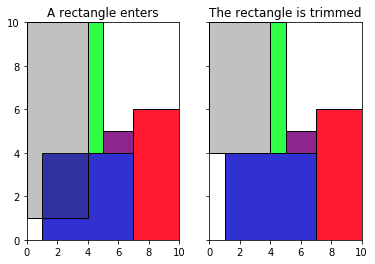

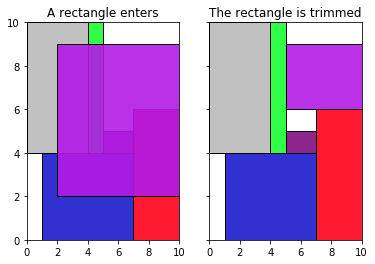

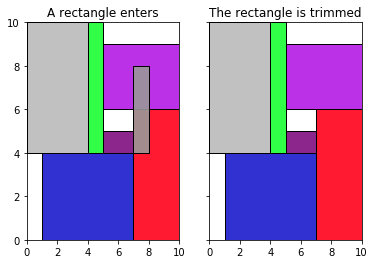

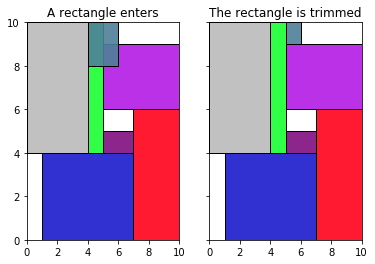

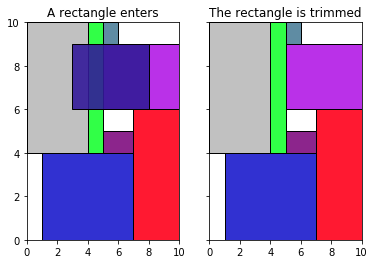

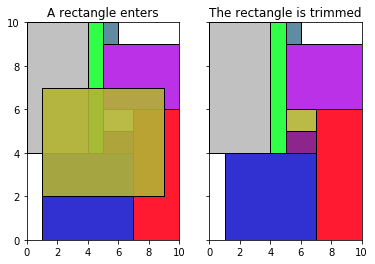

In [11]:
n=1
while n <= len(newlist):
    colors = color = [(0.1,0.1,0.8,0.9), (0.1,1,0.2,0.9), (1,0,0.1,0.9), (0.5,0.05,0.5,0.9), (0.9,0.9,0,0.9), (0.2,0.2,0.2,0.3), (0.7,0.1,0.9,0.9), (0.6,0.6,0.6,0.9), (0.3,0.5,0.6,0.9), (0.2,0.1,0.6,0.9), (0.7,0.7,0.2,0.9)]
    fig,(ax1,ax2) = plt.subplots(1,2, sharex = True, sharey = True)
    ax1.set_title('A rectangle enters')
    ax2.set_title('The rectangle is trimmed')
    plt.axis([0,10,0,10])
    for i in range(n):
        if i == n-1:
            old = mpatches.Rectangle(oldlist[i].x1,oldlist[i].length,oldlist[i].width,fc=colors[i%len(colors)],ec = (0,0,0,1))
            ax1.add_patch(old)
        else:
            old = mpatches.Rectangle(newlist[i].x1,newlist[i].length,newlist[i].width,fc=colors[i%len(colors)],ec = (0,0,0,1))
            ax1.add_patch(old)
    
        new = mpatches.Rectangle(newlist[i].x1,newlist[i].length,newlist[i].width,fc=colors[i%len(colors)],ec = (0,0,0,1))
        ax2.add_patch(new)
    n+=1

# Questions

Given an overall desired coverage footprint and a sequence of n communications towers, what is the resulting resolved coverage?  

From above, we set the total desired coverage 10x10 and n = 10

In [13]:
resolved_area = total_area(newlist)
print "The resulting resolved coverage is: %d"%(resolved_area)

The resulting resolved coverage is: 92


What is the total area of coverage relative to the desired total coverage area of the original footprint? That is, are there any gaps in coverage?

In [17]:
ratio = float(resolved_area)/(length*width)
print "The ratio of coverage area relative to the desired total coverage is: %f"%(ratio)
if ratio < 1:
    print "There are gaps"

The ratio of coverage area relative to the desired total coverage is: 0.920000
There are gaps


On average, how many communications towers are required before full coverage is obtained?  

Before we define a function to generate rectangles given the region a maximum number.  
The generation ends when the region is fully covered or the number rectangles reaches maximum. 
Now we need a new generate function without maximum number.

In [19]:
def coverage(width,length):
    
    """
        Create a square region with where we input our rectangles.
        We want to input rectangles one by one, if a new input is overlapped with old ones,
        we will do the trim and retain a new trimmed rectangle.
        Our goal is to clarify if we can fully cover the whole region.
        Also, for the conveniece to monitor the trimming processes, we will remain the non-trimmed
        rectangle into another list
        
        :Param: length: length of the region
                width: width of the region
        
        :Return: A list of rectangles which are all trimmed.
                 A list of rectangles where the new one has not been trimmed.

    """
    
    assert isinstance(length,int)
    assert isinstance(width,int)
    assert length > 0
    assert width > 0
    
    rectlist = []
    oldlist = []
    area = length*width
    
    while total_area(rectlist) < area:
        new_rect = create_new(length,width)
            
        if len(rectlist) == 0:
            rectlist.append(new_rect)
            oldlist.append(new_rect)
        else:
            oldlist.append(new_rect)
            for rect in rectlist:
                new_rect = trim(rect,new_rect)
            rectlist.append(new_rect)
    
    return rectlist,oldlist

In [30]:
length = 10
width = 10

newlist,oldlist = coverage(length,width)

In [32]:
print "%d communications towers are required before fully coveraging %d * %d region"%(len(newlist),length,width)

28 communications towers are required before fully coveraging 10 * 10 region


# Self-examination 

Sincerely this is my first independent individual project on programming since I have almost zero experience on programming before taking this class.

There are so many problems in this code, an obvious one is the trimming function. Since the function takes two rectangles as parameter and compare them, but we are constantly input rectangles into a fixed region and there will be more and more rectangles existing. As the rectangles become more, the trimmed section is decided by all the existing rectangles at one time, not one by one comparision. This results in a huge error to the final result.  But it is too late for me to fix the function.

I think some linear algebra algorithom might be useful for this question, that is to say, we may consider a rectangle as a matrix whose entries are consisted by '1'. The original region can be viewed as a huge matrix consisted of '0'. Then it becomes easier to calculate the overlapped section since we only need to find overlapped '1' entries.
 
The whole process is unforgettable. At least I finish this project all by myself, which is hard to imagine in previous time.

Thanks.